# Explore Deriative Analysis

In [1]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from ocpy.hydrolight import loisel23
from ocpy.utils import plotting as oc_plotting
from ocpy.satellites import pace as sat_pace

from bing.models import anw as boring_anw
from bing.models import bbnw as boring_bbnw
from bing.models import utils as model_utils
from bing.models import functions
from bing import inference as big_inf
from bing import rt as big_rt
from bing import chisq_fit


In [2]:
%matplotlib ipympl

# Load up Loisel+2023 Hydrolight dataset

## Using the full run (inelastic scattering) at Zenith

In [3]:
ds = loisel23.load_ds(4,0)

In [4]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
all_a = ds.a.data
all_bb = ds.bb.data
all_adg = ds.ag.data + ds.ad.data
all_ad = ds.ad.data
all_ag = ds.ag.data
all_aph = ds.aph.data
all_anw = ds.anw.data

In [5]:
aw = all_a[0] - all_anw[0]

In [6]:
all_anw.shape

(3320, 81)

# Setup

In [7]:
i440 = np.argmin(np.abs(l23_wave-440.))

# $a_{\rm nw}$ histogram at 440nm

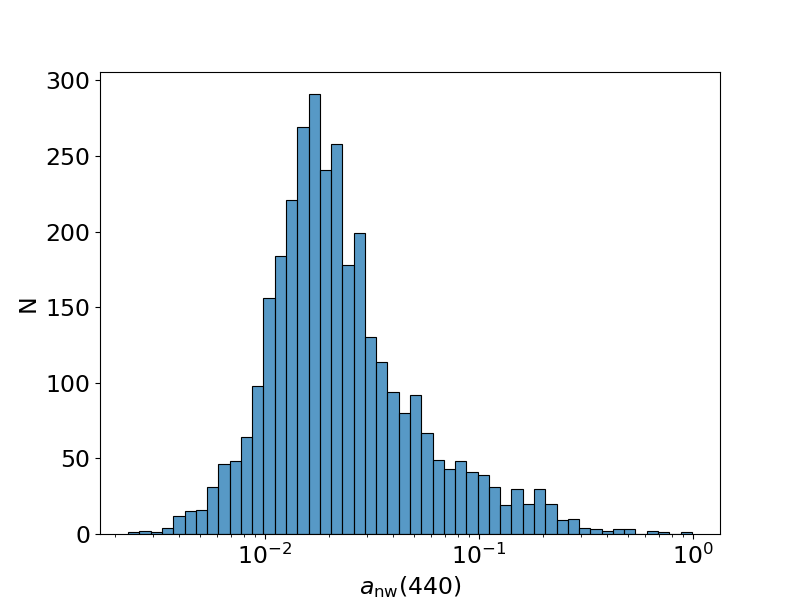

In [8]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

sns.histplot(all_anw[:,i440], log_scale=(True,False))
#
ax.set_xlabel(r'$a_{\rm nw}(440)$')
ax.set_ylabel('N')
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_xscale('log')
plt.show()

# Grab 3 examples

## Lowest $a_{\rm nw}$
## "Normal" $a_{\rm nw}$
## Highest $a_{\rm nw}$

In [9]:
idx_low = np.argmin(all_anw[:,i440])
idx_norm = 170
idx_high = np.argmax(all_anw[:,i440])

## Check

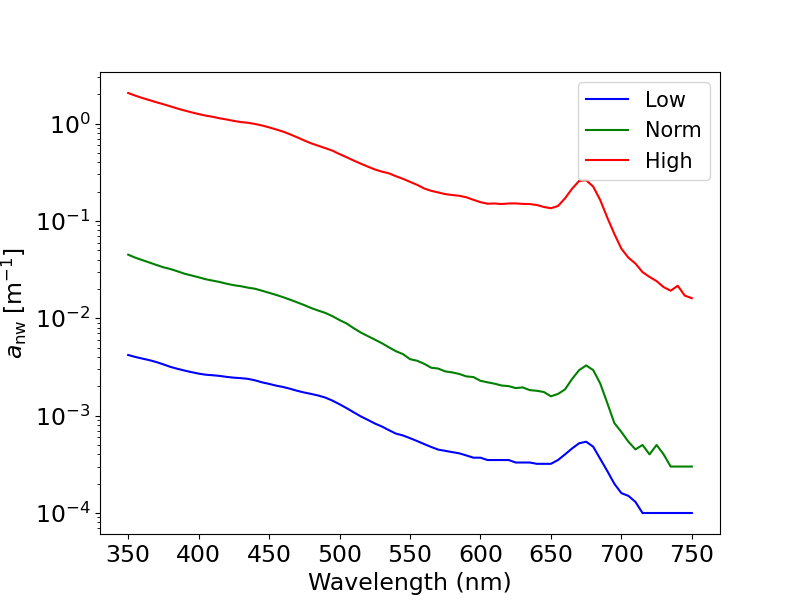

In [10]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, all_anw[idx_low], 'blue', label='Low')
ax.plot(l23_wave, all_anw[idx_norm], 'green', label='Norm')
ax.plot(l23_wave, all_anw[idx_high], 'red', label='High')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$a_{\rm nw} \; \rm [m^{-1}]$')
#
ax.set_yscale('log')
plt.show()

# $R_{\rm rs}$

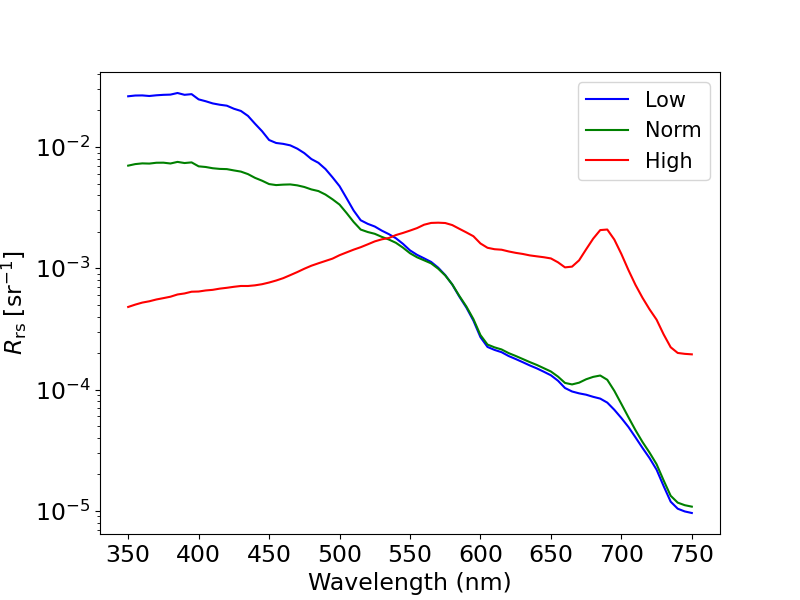

In [11]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, l23_Rrs[idx_low], 'blue', label='Low')
ax.plot(l23_wave, l23_Rrs[idx_norm], 'green', label='Norm')
ax.plot(l23_wave, l23_Rrs[idx_high], 'red', label='High')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$R_{\rm rs} \; \rm [sr^{-1}]$')
#
ax.set_yscale('log')
plt.show()

# Second derivative! $R_{\rm rs}''$

## $R_i'' = \frac{R_{i+1} - 2R_i + R_{i-1}}{\lambda_i^2}$

In [12]:
def d2fd2x(wave, spec):
    dwv = np.abs(np.median(np.roll(wave,1) - wave))
    #
    um1 = np.roll(spec,-1)
    up1 = np.roll(spec,1)
    # Do it
    tmp = (um1 + up1 - 2*spec)
    # Set the boundaries to 0
    tmp[0] = 0
    tmp[-1] = 0
    #import pdb; pdb.set_trace()
    return tmp/dwv**2

## Variance

## $\sigma(R_i'')^2 = \frac{\sigma(R_{i+1})^2 + 4 \sigma(R_i)^2 + \sigma(R_{i-1})^2}{\lambda_i^4}$

### This assumes independent measurements (i.e. we have not included any cross terms).  

### If the variance in $R_i$ is correlated with neighboring pixels, e.g. due to atmospheric corrections, then cross-terms could reduce (or increase) $\sigma(R'')^2$.

### We will allow for a reduction in what follows

In [13]:
def varfpp(wave, spec, s2n:float=None, abs_sig:float=None, reduce_factor:float=None):
    dwv = np.abs(np.median(np.roll(wave,1) - wave))
    # Calculate the error array
    if s2n is not None:
        sig_spec = spec / s2n
    else:
        sig_spec = abs_sig
    #
    um1 = np.roll(sig_spec,-1)
    up1 = np.roll(sig_spec,1)
    # Do it
    tmp = (um1**2 + up1**2 + 4*sig_spec**2)
    # Set the boundaries to 0
    tmp[0] = tmp[1]
    tmp[-1] = tmp[-2]
    #import pdb; pdb.set_trace()
    var = tmp/dwv**4
    if reduce_factor is not None:
        var *= reduce_factor
    # Return
    return var

## For the error array, let's use the PACE estimation from our BING paper

In [14]:
l23_PACE_error = sat_pace.gen_noise_vector(l23_wave)

## Calculate with a 50% reduction factor

In [15]:
Rpp_low = d2fd2x(l23_wave, l23_Rrs[idx_low]) 
Rpp_norm = d2fd2x(l23_wave, l23_Rrs[idx_norm]) 
Rpp_high = d2fd2x(l23_wave, l23_Rrs[idx_high]) 
#
varRpp_low = varfpp(l23_wave, l23_Rrs[idx_low], abs_sig=l23_PACE_error, reduce_factor=0.5) 
varRpp_norm = varfpp(l23_wave, l23_Rrs[idx_norm], abs_sig=l23_PACE_error, reduce_factor=0.5) 
varRpp_high = varfpp(l23_wave, l23_Rrs[idx_high], abs_sig=l23_PACE_error, reduce_factor=0.5) 
#
sigRpp_low = np.sqrt(varRpp_low)
sigRpp_norm = np.sqrt(varRpp_norm)
sigRpp_high = np.sqrt(varRpp_high)

## Plot $R''$

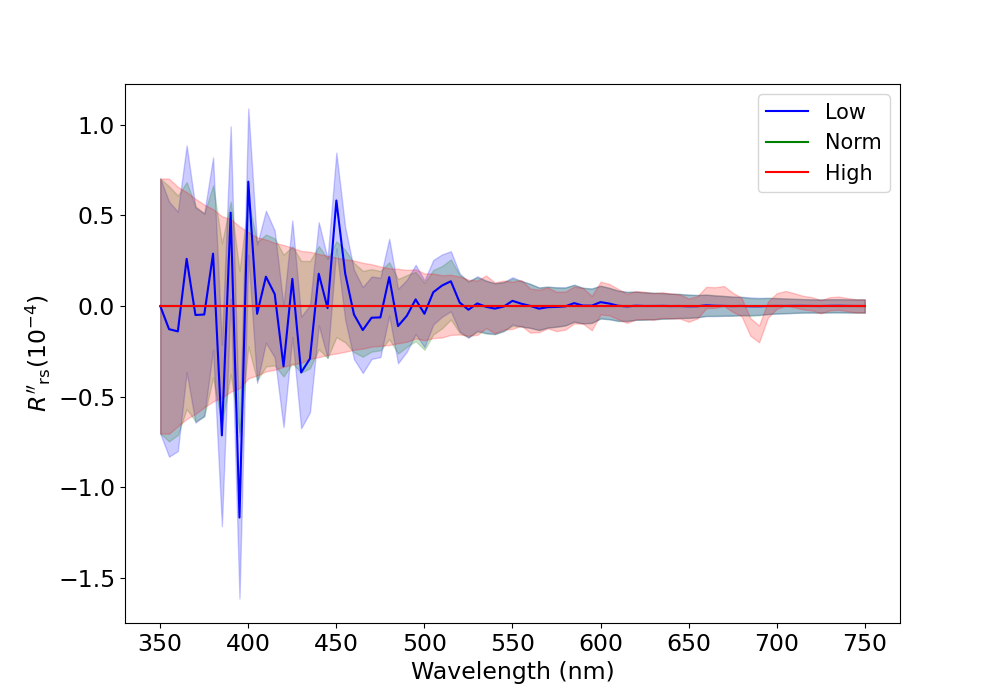

In [19]:
scl = 1e4
fig = plt.figure(figsize=(10,7))
ax = plt.gca()
#
alpha = 0.2
ax.plot(l23_wave, Rpp_low*scl, 'blue', label='Low')
ax.fill_between(l23_wave, Rpp_low*scl-sigRpp_low*scl, Rpp_low*scl+sigRpp_low*scl, color='blue', alpha=alpha)

ax.plot(l23_wave, Rpp_norm, 'green', label='Norm')
ax.fill_between(l23_wave, Rpp_norm*scl-sigRpp_norm*scl, Rpp_norm*scl+sigRpp_norm*scl, color='green', alpha=alpha)

ax.plot(l23_wave, Rpp_high, 'red', label='High')
ax.fill_between(l23_wave, Rpp_high*scl-sigRpp_high*scl, Rpp_high*scl+sigRpp_high*scl, color='red', alpha=alpha)
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r"$R''_{\rm rs} (10^{-4})$")
#
#ax.set_yscale('log')
plt.show()

## Stats

In [19]:
def stats(Rpp, sigRpp, verbose:bool=False):
    # 1 sigma depatures
    one_sig = np.abs(Rpp) > sigRpp
    #
    three_sig = np.abs(Rpp) > 3*sigRpp
    # Print me
    if verbose:
        print(f'We have {np.sum(one_sig)} pixels above 1-sigma')
        print(f'We have {np.sum(three_sig)} pixels above 3-sigma')
    #
    return one_sig, three_sig

In [20]:
for lbl, Rpp, sigRpp in zip(['low', 'norm', 'high'],  [Rpp_low, Rpp_norm, Rpp_high], 
                            [sigRpp_low, sigRpp_norm, sigRpp_high]):
    one, three = stats(Rpp, sigRpp)
    # 
    print(f'For {lbl}: We have {np.sum(one)} pixels above 1-sigma')
    print(f'        and {np.sum(three)} pixels above 3-sigma')

For low: We have 6 pixels above 1-sigma
        and 0 pixels above 3-sigma
For norm: We have 0 pixels above 1-sigma
        and 0 pixels above 3-sigma
For high: We have 4 pixels above 1-sigma
        and 1 pixels above 3-sigma


## There appear to be a few features that are offset from 0 by more than $1 \sigma$ and only one in the highest $a_{\rm nw}$ at $3 \sigma$.

## That is the flourescence feature at $\approx 680$nm

# JXP concludes that it will be very hard, probably impossible, to do science with $R_{\rm rs}''$

## And don't even think about $R_{\rm rs}''''$

----

## Plot $|R''|$

In [68]:
def maxabssig(Rpp, sigRpp):
    maxR = Rpp + sigRpp
    neg = Rpp < 0.
    maxR[neg] = np.minimum(maxR[neg], 0.)
    #
    return np.abs(maxR)

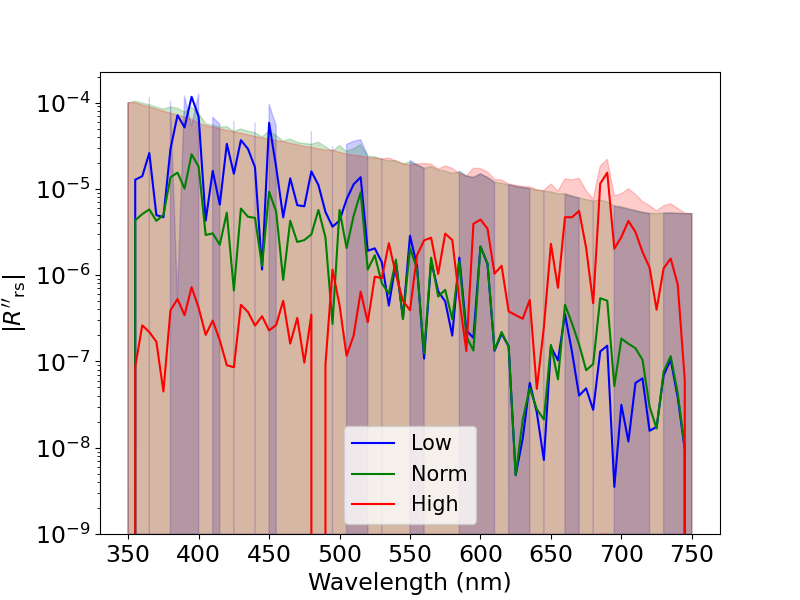

In [69]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, np.abs(Rpp_low), 'blue', label='Low')
ax.fill_between(l23_wave, np.minimum(np.abs(Rpp_low-sigRpp_low), 1e-9), 
                maxabssig(Rpp_low,sigRpp_low), color='blue', alpha=alpha)

ax.plot(l23_wave, np.abs(Rpp_norm), 'green', label='Norm')
ax.fill_between(l23_wave, np.minimum(np.abs(Rpp_norm)-sigRpp_norm, 1e-9), 
                np.abs(Rpp_norm)+sigRpp_norm, color='green', alpha=alpha)

ax.plot(l23_wave, np.abs(Rpp_high), 'red', label='High')
ax.fill_between(l23_wave, np.minimum(np.abs(Rpp_high)-sigRpp_high, 1e-9), 
                np.abs(Rpp_high)+sigRpp_high, color='red', alpha=alpha)
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r"$|R''_{\rm rs}|$")
#
ax.set_yscale('log')
ax.set_ylim(1e-9,None)
plt.show()

----

## Calculate em
d2a = d2fd2x(l23_wave, a)
d2aph = d2fd2x(l23_wave, aph)
d2ag = d2fd2x(l23_wave, ag)
d2ad = d2fd2x(l23_wave, ad)
d2aw = d2fd2x(l23_wave, aw)

## Plot em

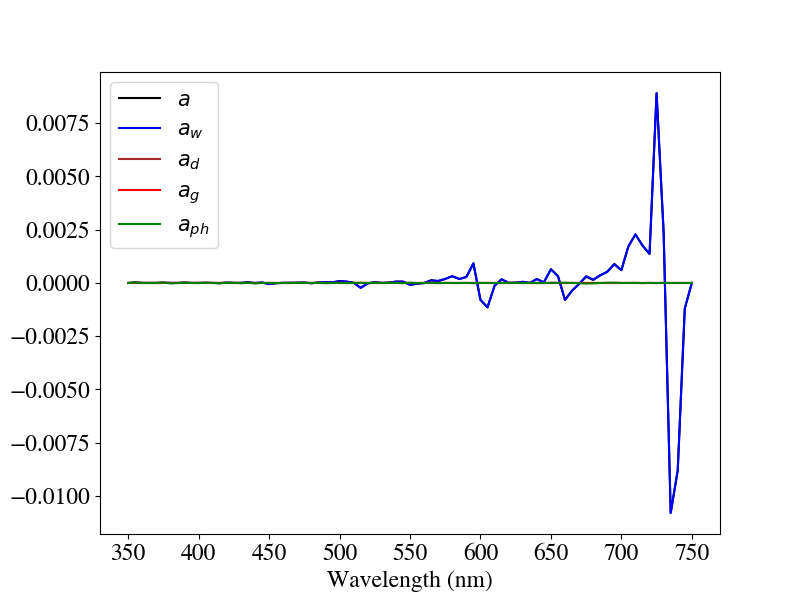

In [38]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, d2a, 'k', label=r'$a$')
ax.plot(l23_wave, d2aw, 'b', label=r'$a_w$')
ax.plot(l23_wave, d2ad, color='brown', label=r'$a_d$')
ax.plot(l23_wave, d2ag, color='r', label=r'$a_g$')
ax.plot(l23_wave, d2aph, color='green', label=r'$a_{ph}$')
#
#ax.plot(l23_wave, aw+ad+ag+aph, color='gray', ls=':', label=r'$a_{ph}$')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$d^2 x / d\lambda^2$')
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_yscale('log')
plt.show()

## Magnitude $|d^2 x / d\lambda^2|$

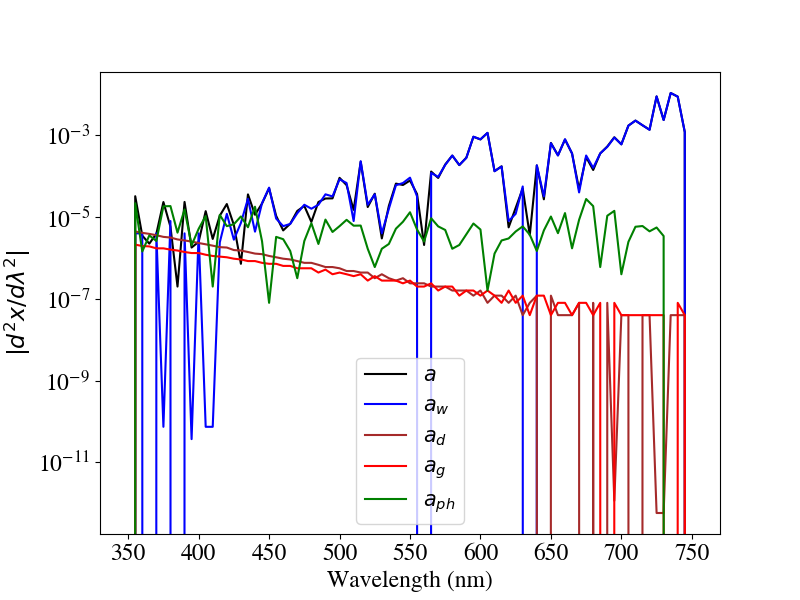

In [25]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, np.abs(d2a), 'k', label=r'$a$')
ax.plot(l23_wave, np.abs(d2aw), 'b', label=r'$a_w$')
ax.plot(l23_wave, np.abs(d2ad), color='brown', label=r'$a_d$')
ax.plot(l23_wave, np.abs(d2ag), color='r', label=r'$a_g$')
ax.plot(l23_wave, np.abs(d2aph), color='green', label=r'$a_{ph}$')
#
#ax.plot(l23_wave, aw+ad+ag+aph, color='gray', ls=':', label=r'$a_{ph}$')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$|d^2 x / d\lambda^2|$')
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
ax.set_yscale('log')
plt.show()

----

In [39]:
idx = 170

In [40]:
a = all_a[idx]
adg = all_adg[idx]
ad = all_ad[idx]
ag = all_ag[idx]
aph = all_aph[idx]

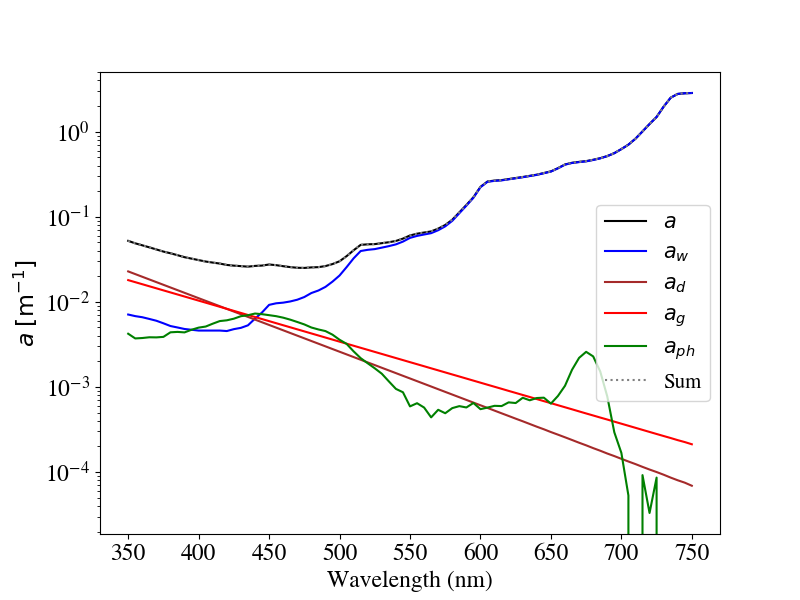

In [41]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(l23_wave, a, 'k', label=r'$a$')
ax.plot(l23_wave, aw, 'b', label=r'$a_w$')
ax.plot(l23_wave, ad, color='brown', label=r'$a_d$')
ax.plot(l23_wave, ag, color='r', label=r'$a_g$')
ax.plot(l23_wave, aph, color='green', label=r'$a_{ph}$')
#
ax.plot(l23_wave, aw+ad+ag+aph, color='gray', ls=':', label='Sum')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$a \; \rm [m^{-1}]$')
#
ax.set_yscale('log')
plt.show()